In [1]:
%load_ext autoreload
%autoreload 2
p = print

from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.optimizers import Adam
from keras.callbacks import TensorBoard

from crypr.zoo import LSTM_triggerNG
from crypr.util import get_project_path

Using TensorFlow backend.


In [2]:
"""
Import Data.
"""
SYM = 'BTC'
Ty = 1
Tx = 72
num_channels = 8
data_dir = join(get_project_path(), 'data', 'processed')

X_train = np.load(join(data_dir, 'X_train_multiple_smooth_{}.npy'.format(SYM)))
X_test = np.load(join(data_dir, 'X_test_multiple_smooth_{}.npy'.format(SYM)))
y_train = np.load(join(data_dir, 'y_train_multiple_smooth_{}.npy'.format(SYM)))
y_test = np.load(join(data_dir, 'y_test_multiple_smooth_{}.npy'.format(SYM)))

In [3]:
X_train.shape, X_test.shape, y_test.shape, y_train.shape

((5616, 72, 8), (216, 72, 8), (216, 1), (5616, 1))

In [4]:
"""
Evaluate Dummy Models.
"""
for strategy in ['mean', 'median', 'constant']:
    
    if strategy=='constant':
        dummy=DummyRegressor(strategy=strategy, constant=(0,))
    else:
        dummy=DummyRegressor(strategy=strategy)
        
    p('\nTraining dummy model on training data with strategy {} ...'.format(strategy))
    dummy.fit(X_train, y_train)
    
    p('\nPerformance on train data:')
    dummy_predict_train = dummy.predict(X_train)
    print('{} MAE: {}'.format(strategy, mean_absolute_error(y_true=y_train, y_pred=dummy_predict_train)))
    print('{} MSE: {}'.format(strategy, mean_squared_error(y_true=y_train, y_pred=dummy_predict_train)))
    
    p('\nPerformance on test data:')
    dummy_predict_test = dummy.predict(X_test)
    print('{} MAE: {}'.format(strategy, mean_absolute_error(y_true=y_test, y_pred=dummy_predict_test)))
    print('{} MSE: {}'.format(strategy, mean_squared_error(y_true=y_test, y_pred=dummy_predict_test)))


Training dummy model on training data with strategy mean ...

Performance on train data:
mean MAE: 0.3432040576001234
mean MSE: 0.4508030865104714

Performance on test data:
mean MAE: 0.4908659788065631
mean MSE: 0.521580146077974

Training dummy model on training data with strategy median ...

Performance on train data:
median MAE: 0.34300810707684876
median MSE: 0.4509332254533204

Performance on test data:
median MAE: 0.4908659788065631
median MSE: 0.521052541976807

Training dummy model on training data with strategy constant ...

Performance on train data:
constant MAE: 0.343036730168458
constant MSE: 0.45084082052390495

Performance on test data:
constant MAE: 0.4908659788065631
constant MSE: 0.5212637040932877


In [5]:
"""
Define model.
"""
model = LSTM_triggerNG(tx=Tx, num_channels=num_channels, num_outputs=Ty)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 33, 196)           12740     
_________________________________________________________________
batch_normalization_1 (Batch (None, 33, 196)           784       
_________________________________________________________________
activation_1 (Activation)    (None, 33, 196)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 196)           0         
_________________________________________________________________
lstm_1 (LSTM)        

In [6]:
"""
Set model training parameters.
"""
epochs = 5
batch_size = 32
learning_rate = 1e-3
beta_1 = 0.9
beta_2 = 0.999
decay = 0.01  # TODO: Calculate decay rate? -- decay = learning_rate / epochs

"""
Compile and fit model.
"""
# Callback definition
log_dir = join(get_project_path(), 'logs', 'wt_smooth_rnn_model_dev')
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, batch_size=batch_size, 
                          write_graph=True, write_grads=False, write_images=False)

opt = Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2, decay=decay)

model.compile(loss='mse', optimizer=opt, metrics=['mae'])

fit = model.fit(
    X_train,
    y_train,
    shuffle=False,
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_test, y_test),
    callbacks=[tensorboard],
)

Instructions for updating:
Use tf.cast instead.
Train on 5616 samples, validate on 216 samples
Epoch 1/5
5616/5616 [==============================] - 19s 3ms/step - loss: 16.2109 - mean_absolute_error: 3.2010 - val_loss: 1.6958 - val_mean_absolute_error: 1.0730
Epoch 2/5
5616/5616 [==============================] - 17s 3ms/step - loss: 11.9363 - mean_absolute_error: 2.7438 - val_loss: 2.9794 - val_mean_absolute_error: 1.4188
Epoch 3/5
5616/5616 [==============================] - 18s 3ms/step - loss: 10.0142 - mean_absolute_error: 2.5188 - val_loss: 0.9281 - val_mean_absolute_error: 0.7119
Epoch 4/5
5616/5616 [==============================] - 17s 3ms/step - loss: 8.9061 - mean_absolute_error: 2.3598 - val_loss: 0.8370 - val_mean_absolute_error: 0.6859
Epoch 5/5
5616/5616 [==============================] - 17s 3ms/step - loss: 8.2239 - mean_absolute_error: 2.2548 - val_loss: 0.8505 - val_mean_absolute_error: 0.6873


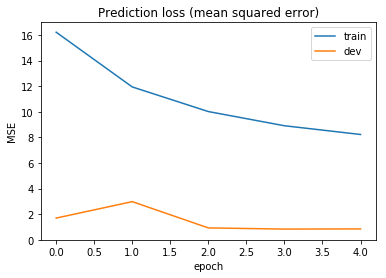

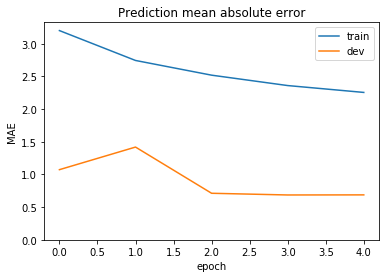

In [7]:
"""
Check out prediction loss from train and dev sets
"""
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], label='dev')
plt.title('Prediction loss (mean squared error)')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.ylim([0, None])
plt.legend()
plt.show()


"""
Check out prediction metric from train and dev sets
"""
plt.plot(fit.history['mean_absolute_error'], label='train')
plt.plot(fit.history['val_mean_absolute_error'], label='dev')
plt.title('Prediction mean absolute error')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.ylim([0, None])
plt.legend()
plt.show()

In [8]:
backtest = model.predict(X_train)
prediction = model.predict(X_test)

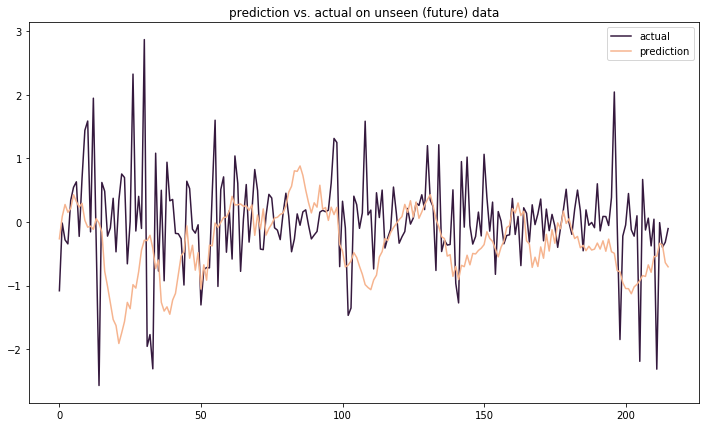

In [9]:
fig, ax = plt.subplots(figsize=(12, 7))
plt.plot(y_test, c=sns.color_palette('rocket')[0], label='actual')
plt.plot(prediction, c=sns.color_palette('rocket')[5], label='prediction')
plt.title('prediction vs. actual on unseen (future) data')
plt.legend()
plt.show()

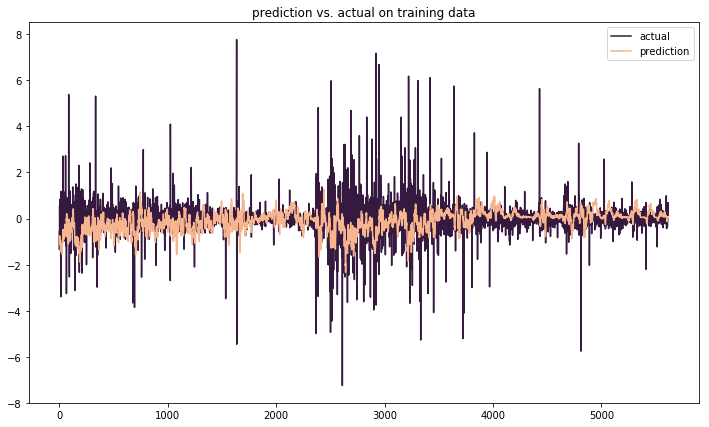

In [10]:
fig, ax = plt.subplots(figsize=(12, 7))
plt.plot(y_train, c=sns.color_palette('rocket')[0], label='actual')
plt.plot(backtest, c=sns.color_palette('rocket')[5], label='prediction')
plt.title('prediction vs. actual on training data')
plt.legend()
plt.show()

In [11]:
"""
Save the model.
"""
model_filepath = join(get_project_path(), 'models', 'wt_smooth_rnn_model_dev.h5')
model.save(filepath=model_filepath)